## 纯位置控制与位置速度控制对比

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 仿真设置
sim_dt = 0.001       # 物理步长 1ms (1000Hz)
decimation = 20      # 决策间隔 (20ms, 50Hz Control) - 模拟 RL 的控制频率
total_time = 2.0     # 总时间
t = np.arange(0, total_time, sim_dt)

# 2. 定义理想轨迹 (Ground Truth Trajectory)
# 我们希望机器人画出的完美曲线
theta_ideal = np.sin(5 * t)
theta_dot_ideal = 5 * np.cos(5 * t)

# 3. 定义 RL 策略输出的目标 (模拟 Zero-Order Hold)
# 在 RL 中，动作在每个环境步(env_step)开始时确定，并在整个 decimation 期间保持不变
# 这意味着物理引擎看到的 target 是一个阶梯状的信号
theta_d_rl = np.zeros_like(t)
theta_dot_d_rl = np.zeros_like(t)

current_target_pos = theta_ideal[0]
current_target_vel = theta_dot_ideal[0]

for i in range(len(t)):
    if i % decimation == 0:
        # 策略更新时刻：采样理想轨迹作为新的 Action
        current_target_pos = theta_ideal[i]
        current_target_vel = theta_dot_ideal[i]
    
    theta_d_rl[i] = current_target_pos
    theta_dot_d_rl[i] = current_target_vel

# 4. 物理参数
Inertia = 0.1   # 转动惯量
Kp = 100.0      # 刚度
Kd = 5.0        # 阻尼

# 5. 仿真循环
# System A: Standard RL (Pos Only) 
# 只有阶梯状的位置目标，速度目标默认为 0 (因为是 Setpoint，我们希望它停在那里)
theta_A = 0.0
theta_dot_A = 0.0
history_A = []

# System B: RL with Velocity Output 
# 阶梯状的位置目标 + 阶梯状的速度目标 (告诉 PD 控制器这个阶梯其实是有速度的)
theta_B = 0.0
theta_dot_B = 0.0
history_B = []

for i in range(len(t)):
    # --- System A (Standard RL: Pos Action Only) ---
    # 误差 = (当前固定的目标位置 - 实时位置)
    # 阻尼项 = (0 - 实时速度) -> Kd 试图阻碍运动，让关节停在目标点
    error_pos_A = theta_d_rl[i] - theta_A
    error_vel_A = 0.0 - theta_dot_A  # 关键区别：没有速度前馈，Kd * (0 - v)
    tau_A = Kp * error_pos_A + Kd * error_vel_A
    
    acc_A = tau_A / Inertia
    theta_dot_A += acc_A * sim_dt
    theta_A += theta_dot_A * sim_dt
    history_A.append(theta_A)

    # --- System B (RL with Velocity Action) ---
    # 误差 = (当前固定的目标位置 - 实时位置)
    # 阻尼项 = (当前固定的目标速度 - 实时速度) -> Kd 试图让关节速度匹配目标速度
    error_pos_B = theta_d_rl[i] - theta_B
    error_vel_B = theta_dot_d_rl[i] - theta_dot_B 
    tau_B = Kp * error_pos_B + Kd * error_vel_B
    
    acc_B = tau_B / Inertia
    theta_dot_B += acc_B * sim_dt
    theta_B += theta_dot_B * sim_dt
    history_B.append(theta_B)

# 6. 绘图
plt.figure(figsize=(12, 8))

# 绘制轨迹
plt.subplot(2, 1, 1)
plt.plot(t, theta_ideal, 'k--', linewidth=1, alpha=0.5, label='Ideal Continuous Trajectory')
plt.step(t[::decimation], theta_d_rl[::decimation], 'k-', where='post', linewidth=1.5, label='RL Action (Step Input)')
plt.plot(t, history_A, 'r-', linewidth=1.5, label='Sys A: Pos Only (Standard RL)')
plt.plot(t, history_B, 'g-', linewidth=1.5, label='Sys B: Pos + Vel Action')
plt.title(f'RL Control Simulation (Decimation={decimation})')
plt.ylabel('Position (rad)')
plt.legend()
plt.grid(True)

# 绘制误差
plt.subplot(2, 1, 2)
plt.plot(t, theta_ideal - history_A, 'r-', label='Error A (Pos Only)')
plt.plot(t, theta_ideal - history_B, 'g-', label='Error B (Pos + Vel)')
plt.title('Tracking Error (vs Ideal Trajectory)')
plt.xlabel('Time (s)')
plt.ylabel('Error (rad)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 雅可比奇异性分析与DLS逆解探讨
![alt text](d6e8fb74-48a0-49a9-bea1-e8c82af1e921.png)
<br>这个例子很不错，可以展示不同位形对末端速度特定方向的生成能力。现在我在研究dls，给定期望速度，通过雅可比伪逆反解得到关节速度。我想要你给一段python代码，研究给定不同的位形、不同的dls阻尼大小对结果的影响，L1,L2长度可自由设置，暂限定于平面

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.widgets import Slider

# ============================================================
#  2-Link Planar Manipulator DLS Inverse Kinematics Analysis
#  
#  Mathematical Model:
#    Forward Kinematics:  p = [L1*c1 + L2*c12,  L1*s1 + L2*s12]^T
#    Jacobian:            J = [[-L1*s1 - L2*s12, -L2*s12],
#                              [ L1*c1 + L2*c12,  L2*c12]]
#    DLS Pseudo-inverse:  J_dls† = J^T (JJ^T + λ²I)^{-1}
#    Velocity IK:         dθ = J_dls† · v_des
# ============================================================

def forward_kinematics(theta1, theta2, L1, L2):
    """Forward Kinematics: compute end-effector position"""
    x = L1 * np.cos(theta1) + L2 * np.cos(theta1 + theta2)
    y = L1 * np.sin(theta1) + L2 * np.sin(theta1 + theta2)
    return np.array([x, y])

def compute_jacobian(theta1, theta2, L1, L2):
    """Compute Jacobian matrix J ∈ R^{2×2}"""
    s1, c1 = np.sin(theta1), np.cos(theta1)
    s12, c12 = np.sin(theta1 + theta2), np.cos(theta1 + theta2)
    
    J = np.array([
        [-L1*s1 - L2*s12, -L2*s12],
        [ L1*c1 + L2*c12,  L2*c12]
    ])
    return J

def dls_inverse(J, lambd):
    """
    DLS (Damped Least Squares) Pseudo-inverse
    
    J_dls† = J^T (JJ^T + λ²I)^{-1}
    
    When λ→0, degenerates to Moore-Penrose pseudo-inverse
    When λ is large, sacrifices accuracy for stability
    """
    m = J.shape[0]  # output dimension
    JJT = J @ J.T
    return J.T @ np.linalg.inv(JJT + lambd**2 * np.eye(m))

def compute_manipulability_ellipse(J):
    """
    Compute manipulability ellipsoid parameters
    
    Ellipsoid determined by eigenvalues/eigenvectors of JJ^T:
    - sqrt(eigenvalues) = ellipsoid semi-axis lengths
    - eigenvectors = principal axis directions
    - manipulability μ = sqrt(det(JJ^T)) = |det(J)|
    """
    JJT = J @ J.T
    eigvals, eigvecs = np.linalg.eigh(JJT)
    
    # Semi-axis lengths
    axes = np.sqrt(np.maximum(eigvals, 0))
    # Ellipsoid rotation angle
    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
    # Manipulability index
    manipulability = np.sqrt(np.maximum(np.linalg.det(JJT), 0))
    
    return axes, angle, manipulability

def plot_arm_and_ellipse(ax, theta1, theta2, L1, L2, title=""):
    """Plot manipulator and manipulability ellipsoid"""
    # Joint positions
    p0 = np.array([0, 0])
    p1 = np.array([L1 * np.cos(theta1), L1 * np.sin(theta1)])
    p2 = forward_kinematics(theta1, theta2, L1, L2)
    
    # Draw links
    ax.plot([p0[0], p1[0]], [p0[1], p1[1]], 'b-', lw=4, label='Link 1')
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'r-', lw=4, label='Link 2')
    
    # Draw joints
    ax.plot(*p0, 'ko', ms=10)
    ax.plot(*p1, 'ko', ms=8)
    ax.plot(*p2, 'go', ms=8, label='End-effector')
    
    # Compute and draw manipulability ellipsoid
    J = compute_jacobian(theta1, theta2, L1, L2)
    axes, angle, mu = compute_manipulability_ellipse(J)
    
    ellipse = Ellipse(xy=p2, width=2*axes[0], height=2*axes[1], 
                      angle=angle, fill=False, color='purple', lw=2)
    ax.add_patch(ellipse)
    
    # Annotations
    ax.set_title(f'{title}\nmu = {mu:.3f}, det(J) = {np.linalg.det(J):.3f}')
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=8)

In [ ]:

# ============================================================
#  Part 1: Manipulability Ellipsoid Comparison for Different Configs
# ============================================================
L1, L2 = 1.0, 1.0  # Link lengths

# Define typical configurations
configurations = [
    (np.pi/4, np.pi/2, "Extended Config\n(High Manipulability)"),
    (np.pi/4, np.pi, "Fully Stretched\n(Singular Config)"),
    (np.pi/4, 0, "Folded Config"),
    (np.pi/2, -np.pi/2, "Reverse Bend"),
]

fig1, axes1 = plt.subplots(2, 2, figsize=(12, 12))
axes1 = axes1.flatten()

for i, (th1, th2, name) in enumerate(configurations):
    plot_arm_and_ellipse(axes1[i], th1, th2, L1, L2, name)

plt.suptitle('2-Link Manipulator: Manipulability Ellipsoid for Different Configs', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:

# ============================================================
#  Part 2: Effect of DLS Damping Coefficient on Inverse Solution
# ============================================================
fig2, axes2 = plt.subplots(2, 3, figsize=(15, 10))

# Desired end-effector velocity
v_desired = np.array([1.0, 0.5])

# Test different configurations
test_configs = [
    (np.pi/4, np.pi/2, "Normal Config (theta2=90 deg)"),
    (np.pi/4, np.pi - 0.1, "Near-Singular Config (theta2 approx 180 deg)"),
]

lambda_values = np.logspace(-3, 1, 100)  # λ from 0.001 to 10

for row, (th1, th2, config_name) in enumerate(test_configs):
    J = compute_jacobian(th1, th2, L1, L2)
    det_J = np.linalg.det(J)
    
    # Compute joint velocities for different λ
    dtheta_norms = []
    dtheta1_list = []
    dtheta2_list = []
    tracking_errors = []
    
    for lambd in lambda_values:
        J_dls_inv = dls_inverse(J, lambd)
        dtheta = J_dls_inv @ v_desired
        
        dtheta_norms.append(np.linalg.norm(dtheta))
        dtheta1_list.append(dtheta[0])
        dtheta2_list.append(dtheta[1])
        
        # Tracking error: ||J*dθ - v_des||
        v_actual = J @ dtheta
        tracking_errors.append(np.linalg.norm(v_actual - v_desired))
    
    # Plot joint velocity norm
    axes2[row, 0].semilogx(lambda_values, dtheta_norms, 'b-', lw=2, label='||d_theta||')
    axes2[row, 0].set_xlabel('lambda (damping coeff)')
    axes2[row, 0].set_ylabel('||d_theta|| (joint vel norm)')
    axes2[row, 0].set_title(f'{config_name}\ndet(J)={det_J:.4f}')
    axes2[row, 0].grid(True, alpha=0.3)
    axes2[row, 0].legend()
    
    # Plot individual joint velocities
    axes2[row, 1].semilogx(lambda_values, dtheta1_list, 'r-', lw=2, label='d_theta1')
    axes2[row, 1].semilogx(lambda_values, dtheta2_list, 'g-', lw=2, label='d_theta2')
    axes2[row, 1].set_xlabel('lambda (damping coeff)')
    axes2[row, 1].set_ylabel('Joint velocity (rad/s)')
    axes2[row, 1].set_title('Individual Joint Velocities')
    axes2[row, 1].grid(True, alpha=0.3)
    axes2[row, 1].legend()
    
    # Plot tracking error
    axes2[row, 2].loglog(lambda_values, tracking_errors, 'm-', lw=2, label='tracking error')
    axes2[row, 2].set_xlabel('lambda (damping coeff)')
    axes2[row, 2].set_ylabel('||J*d_theta - v_des|| (tracking err)')
    axes2[row, 2].set_title('End-Effector Velocity Tracking Error')
    axes2[row, 2].grid(True, alpha=0.3)
    axes2[row, 2].legend()

plt.suptitle(f'DLS Inverse Solution Analysis: v_des = {v_desired}', fontsize=14)
plt.tight_layout()
plt.show()

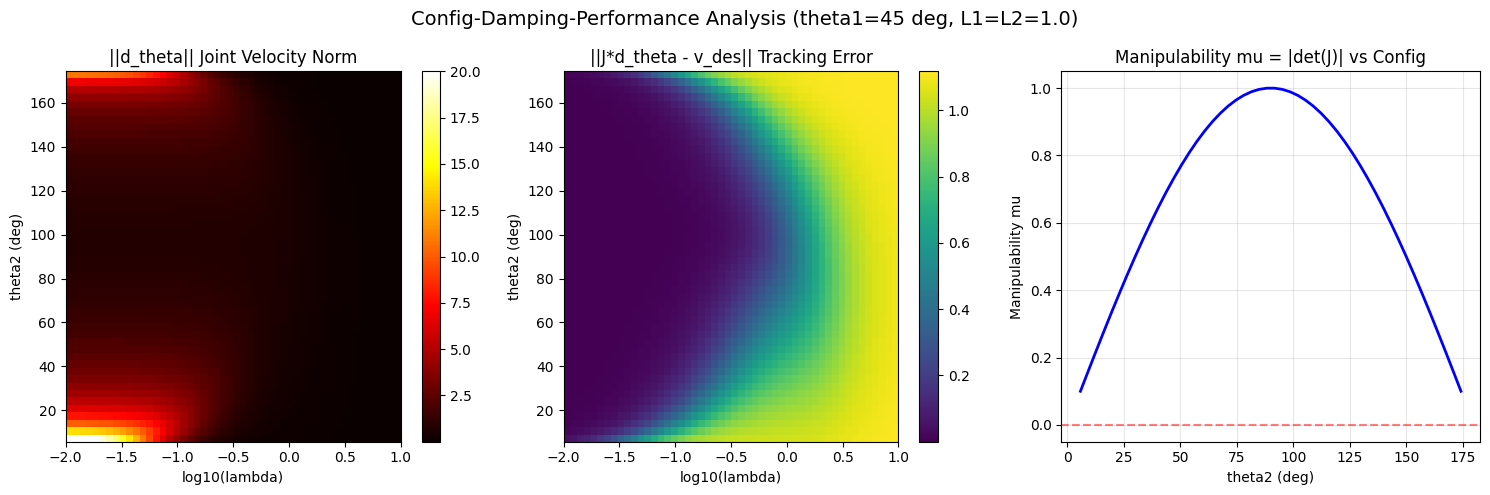

In [12]:

# ============================================================
#  Part 3: Config-Damping-Performance Heatmap
# ============================================================
fig3, axes3 = plt.subplots(1, 3, figsize=(15, 5))

theta2_range = np.linspace(0.1, np.pi - 0.1, 50)  # θ₂ from 0 to 180°
lambda_range = np.logspace(-2, 1, 50)

# Fixed θ₁ = 45°
theta1_fixed = np.pi / 4

# Store results
joint_vel_norm = np.zeros((len(theta2_range), len(lambda_range)))
tracking_error = np.zeros((len(theta2_range), len(lambda_range)))
manipulability = np.zeros(len(theta2_range))

for i, th2 in enumerate(theta2_range):
    J = compute_jacobian(theta1_fixed, th2, L1, L2)
    _, _, mu = compute_manipulability_ellipse(J)
    manipulability[i] = mu
    
    for j, lambd in enumerate(lambda_range):
        J_dls_inv = dls_inverse(J, lambd)
        dtheta = J_dls_inv @ v_desired
        
        joint_vel_norm[i, j] = np.linalg.norm(dtheta)
        tracking_error[i, j] = np.linalg.norm(J @ dtheta - v_desired)

# Heatmap 1: Joint velocity norm
im1 = axes3[0].imshow(joint_vel_norm, aspect='auto', origin='lower',
                       extent=[np.log10(lambda_range[0]), np.log10(lambda_range[-1]),
                               np.degrees(theta2_range[0]), np.degrees(theta2_range[-1])],
                       cmap='hot', vmax=20)
axes3[0].set_xlabel('log10(lambda)')
axes3[0].set_ylabel('theta2 (deg)')
axes3[0].set_title('||d_theta|| Joint Velocity Norm')
plt.colorbar(im1, ax=axes3[0])

# Heatmap 2: Tracking error
im2 = axes3[1].imshow(tracking_error, aspect='auto', origin='lower',
                       extent=[np.log10(lambda_range[0]), np.log10(lambda_range[-1]),
                               np.degrees(theta2_range[0]), np.degrees(theta2_range[-1])],
                       cmap='viridis')
axes3[1].set_xlabel('log10(lambda)')
axes3[1].set_ylabel('theta2 (deg)')
axes3[1].set_title('||J*d_theta - v_des|| Tracking Error')
plt.colorbar(im2, ax=axes3[1])

# Curve: Manipulability vs θ₂
axes3[2].plot(np.degrees(theta2_range), manipulability, 'b-', lw=2)
axes3[2].set_xlabel('theta2 (deg)')
axes3[2].set_ylabel('Manipulability mu')
axes3[2].set_title('Manipulability mu = |det(J)| vs Config')
axes3[2].grid(True, alpha=0.3)
axes3[2].axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.suptitle(f'Config-Damping-Performance Analysis (theta1={np.degrees(theta1_fixed):.0f} deg, L1=L2={L1})', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:

# ============================================================
#  Part 4: Summary
# ============================================================
print("=" * 60)
print("DLS (Damped Least Squares) Inverse Kinematics Key Conclusions:")
print("=" * 60)
print("""
1. [Singularity Issue]
   When theta2 -> 0 deg or 180 deg, det(J) -> 0, manipulator enters singular config
   Standard pseudo-inverse J+ produces extremely large joint velocities
   
2. [Role of DLS]
   J_dls_dag = J^T (JJ^T + lambda^2 I)^{-1}
   - Small lambda: High tracking accuracy, but unstable near singularity
   - Large lambda: Sacrifices accuracy for stability
   
3. [Trade-off]
   From heatmaps:
   - Near singular configs (theta2 ~ 180 deg), larger lambda needed to suppress joint vel
   - But too large lambda increases end-effector velocity tracking error
   
4. [Manipulability Ellipsoid]
   Ellipsoid shape reflects end-effector velocity generation capability:
   - Circular ellipsoid = isotropic (omnidirectional dexterity)
   - Flat ellipsoid = loss of dexterity in certain directions (near singularity)
""")

### 交互性探索奇异性
关键发现 $\mu = \sqrt{\det(JJ^\mathrm{T})} = | \det(J) | = L_1 L_2 |\sin\theta_2|$ 只和 第二个关节角度有关，且在 $\theta_2 = 0$ 或 $\pi$ 时达到奇异点 $\mu=0$。此时末端无法产生垂直于连杆方向的速度分量。

In [11]:
# 点击运行即可
# ============================================================
#  Interactive Version: Real-time Manipulability Ellipsoid
#  Use sliders to adjust joint angles and observe changes
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import ipywidgets as widgets
from IPython.display import display, clear_output

# Redefine functions for this cell (self-contained)
def forward_kinematics(theta1, theta2, L1, L2):
    x = L1 * np.cos(theta1) + L2 * np.cos(theta1 + theta2)
    y = L1 * np.sin(theta1) + L2 * np.sin(theta1 + theta2)
    return np.array([x, y])

def compute_jacobian(theta1, theta2, L1, L2):
    s1, c1 = np.sin(theta1), np.cos(theta1)
    s12, c12 = np.sin(theta1 + theta2), np.cos(theta1 + theta2)
    J = np.array([
        [-L1*s1 - L2*s12, -L2*s12],
        [ L1*c1 + L2*c12,  L2*c12]
    ])
    return J

def compute_manipulability_ellipse(J):
    JJT = J @ J.T
    eigvals, eigvecs = np.linalg.eigh(JJT)
    axes = np.sqrt(np.maximum(eigvals, 0))
    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
    manipulability = np.sqrt(np.maximum(np.linalg.det(JJT), 0))
    return axes, angle, manipulability

# Link lengths
L1, L2 = 1.0, 1.0

# Create output widget for matplotlib figure
output = widgets.Output()

def update_plot(theta1_deg, theta2_deg):
    """Update the plot based on slider values"""
    theta1 = np.radians(theta1_deg)
    theta2 = np.radians(theta2_deg)
    
    with output:
        clear_output(wait=True)
        
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # Joint positions
        p0 = np.array([0, 0])
        p1 = np.array([L1 * np.cos(theta1), L1 * np.sin(theta1)])
        p2 = forward_kinematics(theta1, theta2, L1, L2)
        
        # Draw links
        ax.plot([p0[0], p1[0]], [p0[1], p1[1]], 'b-', lw=6, label='Link 1')
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'r-', lw=6, label='Link 2')
        
        # Draw joints
        ax.plot(*p0, 'ko', ms=12, zorder=5)
        ax.plot(*p1, 'ko', ms=10, zorder=5)
        ax.plot(*p2, 'go', ms=10, zorder=5, label='End-effector')
        
        # Compute Jacobian and manipulability
        J = compute_jacobian(theta1, theta2, L1, L2)
        axes_ellipse, angle, mu = compute_manipulability_ellipse(J)
        det_J = np.linalg.det(J)
        
        # Draw manipulability ellipsoid (scaled for visibility)
        scale = 0.8  # Scale factor for ellipsoid visualization
        ellipse = Ellipse(xy=p2, width=2*axes_ellipse[0]*scale, height=2*axes_ellipse[1]*scale, 
                          angle=angle, fill=False, color='purple', lw=3, label='Manipulability Ellipsoid')
        ax.add_patch(ellipse)
        
        # Draw principal axes of ellipsoid
        for i, (eigval, color) in enumerate(zip(axes_ellipse, ['orange', 'cyan'])):
            angle_rad = np.radians(angle) + i * np.pi/2
            dx = eigval * scale * np.cos(angle_rad)
            dy = eigval * scale * np.sin(angle_rad)
            ax.arrow(p2[0], p2[1], dx, dy, head_width=0.05, head_length=0.03, 
                     fc=color, ec=color, lw=2, alpha=0.7)
        
        # Draw workspace boundary (reachable area)
        theta_ws = np.linspace(0, 2*np.pi, 100)
        # Outer boundary (fully extended)
        ax.plot((L1+L2)*np.cos(theta_ws), (L1+L2)*np.sin(theta_ws), 'g--', alpha=0.3, lw=1)
        # Inner boundary (fully folded)
        ax.plot(abs(L1-L2)*np.cos(theta_ws), abs(L1-L2)*np.sin(theta_ws), 'g--', alpha=0.3, lw=1)
        
        # Labels and formatting
        ax.set_xlim(-2.5, 2.5)
        ax.set_ylim(-2.5, 2.5)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left', fontsize=10)
        
        # Title with metrics
        singular_warning = " [NEAR SINGULAR!]" if abs(det_J) < 0.1 else ""
        ax.set_title(f'Interactive 2-Link Manipulator\n'
                     f'theta1 = {theta1_deg:.1f} deg, theta2 = {theta2_deg:.1f} deg\n'
                     f'Manipulability mu = {mu:.4f}, det(J) = {det_J:.4f}{singular_warning}',
                     fontsize=12)
        
        # Add text box with Jacobian matrix
        textstr = f'J = [{J[0,0]:.3f}, {J[0,1]:.3f}]\n    [{J[1,0]:.3f}, {J[1,1]:.3f}]'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.02, 0.02, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='bottom', fontfamily='monospace', bbox=props)
        
        plt.tight_layout()
        plt.show()

# Create sliders
theta1_slider = widgets.FloatSlider(
    value=45, min=-180, max=180, step=1,
    description='theta1 (deg):',
    style={'description_width': '100px'},
    layout=widgets.Layout(width='500px'),
    continuous_update=True
)

theta2_slider = widgets.FloatSlider(
    value=90, min=-180, max=180, step=1,
    description='theta2 (deg):',
    style={'description_width': '100px'},
    layout=widgets.Layout(width='500px'),
    continuous_update=True
)

# Preset buttons for typical configurations
def set_extended(b):
    theta1_slider.value = 45
    theta2_slider.value = 90

def set_singular_stretched(b):
    theta1_slider.value = 45
    theta2_slider.value = 180

def set_singular_folded(b):
    theta1_slider.value = 45
    theta2_slider.value = 0

def set_best_config(b):
    theta1_slider.value = 90
    theta2_slider.value = 90

btn_extended = widgets.Button(description="Extended (High mu)")
btn_singular_s = widgets.Button(description="Stretched (Singular)")
btn_singular_f = widgets.Button(description="Folded (Singular)")
btn_best = widgets.Button(description="Best Config")

btn_extended.on_click(set_extended)
btn_singular_s.on_click(set_singular_stretched)
btn_singular_f.on_click(set_singular_folded)
btn_best.on_click(set_best_config)

# Layout
buttons_box = widgets.HBox([btn_extended, btn_singular_s, btn_singular_f, btn_best])
sliders_box = widgets.VBox([theta1_slider, theta2_slider])
controls = widgets.VBox([sliders_box, buttons_box])

# Connect sliders to update function
interactive_plot = widgets.interactive_output(
    update_plot, 
    {'theta1_deg': theta1_slider, 'theta2_deg': theta2_slider}
)

# Display
display(controls)
display(output)
update_plot(theta1_slider.value, theta2_slider.value)

Output()

## LeapHand Index Finger 解析雅可比推导
基于 URDF 文件 `source/leaphand/assets/robot.urdf` 中的运动学参数，推导 Index 手指的解析雅可比矩阵。
<br> 
TODO:关节对齐；3D画框浮动出来
> 后续：视觉效果费拉不堪，到时候论文写作我不如自己画图；后面还是老老实实用test_manipulability.py的数值结果吧

![alt text](211ffd25-dc9c-41b3-86f1-b8b2bab90962.png)

In [28]:
# ============================================================
#  3D Interactive Visualization: LeapHand Manipulability Ellipsoid
#  Pinocchio + URDF-derived geometry for faithful joint mapping
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (used by Matplotlib)
import ipywidgets as widgets
from IPython.display import display, clear_output
import pinocchio as pin
from pathlib import Path
import xml.etree.ElementTree as ET

# ========================
#  Load LeapHand URDF & Pinocchio model
# ========================
URDF_PATH = Path("/home/hac/isaac/AnyRotate/source/leaphand/assets/robot.urdf")
assert URDF_PATH.exists(), f"URDF not found: {URDF_PATH}"

model = pin.buildModelFromUrdf(str(URDF_PATH))
data = model.createData()
LOCAL_REV_AXIS = np.array([0.0, 0.0, -1.0])  # axis definition in URDF joint frame

# ========================
#  Joint metadata (auto-enriched with Pinocchio indices)
# ========================
RAW_JOINT_INFO = [
    {
        "q_label": "q0",
        "joint_name": "1",
        "connection": "palm→mcp",
        "role": "Abduction / up-down",
        "deg_limits": (-18.0, 60.0),
        "default_deg": 0.0,
        "color": "magenta",
    },
    {
        "q_label": "q1",
        "joint_name": "0",
        "connection": "mcp→pip",
        "role": "Tangential sweep",
        "deg_limits": (-60.0, 60.0),
        "default_deg": 0.0,
        "color": "cyan",
    },
    {
        "q_label": "q2",
        "joint_name": "2",
        "connection": "pip→dip",
        "role": "Flexion",
        "deg_limits": (-29.0, 108.0),
        "default_deg": 45.0,
        "color": "magenta",
    },
    {
        "q_label": "q3",
        "joint_name": "3",
        "connection": "dip→tip",
        "role": "Flexion (orientation heavy)",
        "deg_limits": (-21.0, 117.0),
        "default_deg": 30.0,
        "color": "magenta",
    },
]

for joint in RAW_JOINT_INFO:
    joint_id = model.getJointId(joint["joint_name"])
    joint["joint_id"] = joint_id
    joint["q_index"] = model.joints[joint_id].idx_q

INDEX_TIP_FRAME_ID = model.getFrameId("fingertip")
VIZ_FRAMES = ["palm_lower", "mcp_joint", "pip", "dip", "fingertip"]

# ========================
#  Visual mesh offsets (so DIP→tip motion becomes visible)
# ========================

def parse_visual_offsets(urdf_path: Path):
    offsets = {}
    tree = ET.parse(urdf_path)
    root = tree.getroot()
    for link in root.findall("link"):
        name = link.get("name")
        visual = link.find("visual")
        if visual is None:
            continue
        origin = visual.find("origin")
        if origin is None:
            continue
        xyz = np.array([float(v) for v in origin.get("xyz", "0 0 0").split()])
        offsets[name] = xyz
    return offsets

VISUAL_OFFSETS = parse_visual_offsets(URDF_PATH)

# ========================
#  Helper utilities
# ========================
def print_joint_summary():
    pin.forwardKinematics(model, data, pin.neutral(model))
    pin.updateFramePlacements(model, data)
    print("=" * 90)
    print("LeapHand Index Finger - Joint Mapping (auto generated)")
    print("=" * 90)
    header = f"{ 'Slider':<6}{'URDF':<6}{'q_idx':<7}{'Connection':<18}{'Axis@world':<26}Role"
    print(header)
    print("-" * 90)
    for info in RAW_JOINT_INFO:
        axis_world = data.oMi[info["joint_id"]].rotation @ LOCAL_REV_AXIS
        axis_str = "[{:+.2f}, {:+.2f}, {:+.2f}]".format(*axis_world)
        print(f"{info['q_label']:<6}{info['joint_name']:<6}{info['q_index']:<7}{info['connection']:<18}{axis_str:<26}{info['role']}")
    print("=" * 90)

print_joint_summary()


def se3_of_frame(frame_name: str):
    return data.oMf[model.getFrameId(frame_name)]


def transform_point(frame_se3, local_point):
    return frame_se3.rotation @ local_point + frame_se3.translation


def get_frame_positions(q_full, frame_names):
    pin.forwardKinematics(model, data, q_full)
    pin.updateFramePlacements(model, data)
    return {name: se3_of_frame(name).translation.copy() for name in frame_names}


def get_joint_axes_world():
    axes = {}
    for info in RAW_JOINT_INFO:
        axes[info["q_label"]] = {
            "origin": data.oMi[info["joint_id"]].translation.copy(),
            "axis": data.oMi[info["joint_id"]].rotation @ LOCAL_REV_AXIS,
            "color": info["color"],
        }
    return axes


def compute_manipulability(J):
    JJ = J @ J.T
    eigvals, eigvecs = np.linalg.eigh(JJ)
    axes = np.sqrt(np.clip(eigvals, 0.0, None))
    mu = np.sqrt(np.clip(np.linalg.det(JJ), 0.0, None))
    cond = np.sqrt(np.max(eigvals) / np.clip(np.min(eigvals), 1e-10, None))
    return axes, eigvecs, mu, cond


def fingertip_visual_point():
    tip_frame = data.oMf[INDEX_TIP_FRAME_ID]
    offset = VISUAL_OFFSETS.get("fingertip", np.zeros(3))
    return transform_point(tip_frame, offset)


def build_configuration_from_degrees(q0_deg, q1_deg, q2_deg, q3_deg):
    q_full = pin.neutral(model)
    for angle_deg, info in zip([q0_deg, q1_deg, q2_deg, q3_deg], RAW_JOINT_INFO):
        q_full[info["q_index"]] = np.radians(angle_deg)
    return q_full


output_3d = widgets.Output()


def update_3d_plot(q0_deg, q1_deg, q2_deg, q3_deg, scale, show_axes, show_ellipsoid):
    q_full = build_configuration_from_degrees(q0_deg, q1_deg, q2_deg, q3_deg)

    with output_3d:
        clear_output(wait=True)

        fig = plt.figure(figsize=(12, 9))
        ax = fig.add_subplot(111, projection="3d")

        # Frame positions
        positions = get_frame_positions(q_full, VIZ_FRAMES)
        
        # Visual tip position (physical tip)
        tip_visual = fingertip_visual_point()
        
        # Define the chain points with Anatomical Names to avoid confusion
        # URDF 'mcp_joint' frame -> Joint 1 (Abduction)
        # URDF 'pip' frame       -> Joint 0 (MCP Flexion)
        # URDF 'dip' frame       -> Joint 2 (PIP Flexion)
        # URDF 'fingertip' frame -> Joint 3 (DIP Flexion)
        
        chain_points = [
            ("Palm", positions["palm_lower"]),
            ("MCP(Abd)", positions["mcp_joint"]),
            ("MCP(Flex)", positions["pip"]),
            ("PIP", positions["dip"]),
            ("DIP", positions["fingertip"]),
            ("Tip", tip_visual),
        ]
        
        # Colors for segments:
        # 1. Palm->MCP(Abd)
        # 2. MCP(Abd)->MCP(Flex)
        # 3. MCP(Flex)->PIP (Proximal Phalanx)
        # 4. PIP->DIP (Middle Phalanx)
        # 5. DIP->Tip (Distal Phalanx)
        link_colors = ["gray", "gray", "royalblue", "limegreen", "orange"]
        link_labels = ["Base", "Base", "Proximal", "Middle", "Distal"]
        
        # Draw chain segments
        for i in range(len(chain_points) - 1):
            p1 = chain_points[i][1]
            p2 = chain_points[i+1][1]
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 
                    color=link_colors[i], linewidth=4, label=link_labels[i])
            
        # Draw Joint Markers
        # We skip the last point (Tip) in this loop, handled separately
        for (name, point) in chain_points[:-1]:
             ax.scatter([point[0]], [point[1]], [point[2]], c='k', s=40, depthshade=False)

        # Mark the physical tip
        ax.scatter([tip_visual[0]], [tip_visual[1]], [tip_visual[2]], 
                   c='red', s=100, marker='*', label='Fingertip', depthshade=False)

        # Optional joint axes
        if show_axes:
            axes_info = get_joint_axes_world()
            axis_len = 0.018
            axis_label_added = False
            for info in RAW_JOINT_INFO:
                axis_entry = axes_info[info["q_label"]]
                origin = axis_entry["origin"]
                axis_vec = axis_entry["axis"] * axis_len
                label = "Joint Axes" if not axis_label_added else None
                ax.quiver(
                    origin[0],
                    origin[1],
                    origin[2],
                    axis_vec[0],
                    axis_vec[1],
                    axis_vec[2],
                    color=axis_entry["color"],
                    linewidth=2.2,
                    arrow_length_ratio=0.25,
                    label=label,
                )
                axis_label_added = True

        # Fingertip orientation triad (helps see q3)
        tip_frame = data.oMf[INDEX_TIP_FRAME_ID]
        triad_len = 0.01
        triad_colors = ["crimson", "seagreen", "navy"]
        for i in range(3):
            vec = tip_frame.rotation[:, i] * triad_len
            ax.quiver(
                tip_frame.translation[0],
                tip_frame.translation[1],
                tip_frame.translation[2],
                vec[0],
                vec[1],
                vec[2],
                color=triad_colors[i],
                linewidth=2,
            )

        # Jacobian / manipulability (evaluated at fingertip origin)
        J_full = pin.computeFrameJacobian(
            model,
            data,
            q_full,
            INDEX_TIP_FRAME_ID,
            pin.ReferenceFrame.LOCAL_WORLD_ALIGNED,
        )
        J = J_full[:3, [info["q_index"] for info in RAW_JOINT_INFO]]
        axes_vals, eigvecs, mu, cond = compute_manipulability(J)
        column_norms = np.linalg.norm(J, axis=0)

        if show_ellipsoid:
            # Draw manipulability ellipsoid at visual tip for easier interpretation
            tip_center = tip_visual
            u = np.linspace(0, 2 * np.pi, 24)
            v = np.linspace(0, np.pi, 24)
            xs = np.outer(np.cos(u), np.sin(v))
            ys = np.outer(np.sin(u), np.sin(v))
            zs = np.outer(np.ones_like(u), np.cos(v))
            for i in range(xs.shape[0]):
                for j in range(xs.shape[1]):
                    vec = np.array([xs[i, j], ys[i, j], zs[i, j]]) * axes_vals * scale
                    xs[i, j], ys[i, j], zs[i, j] = eigvecs @ vec + tip_center
            ax.plot_surface(xs, ys, zs, alpha=0.3, color="mediumpurple", linewidth=0.2)

            # Principal axes
            axis_colors = ["crimson", "darkgreen", "dodgerblue"]
            axes_label_added = False
            for idx, color in enumerate(axis_colors):
                direction = eigvecs[:, idx] * axes_vals[idx] * scale
                label = "Manipulability Axes" if not axes_label_added else None
                ax.quiver(
                    tip_center[0],
                    tip_center[1],
                    tip_center[2],
                    direction[0],
                    direction[1],
                    direction[2],
                    color=color,
                    linewidth=2.0,
                    arrow_length_ratio=0.12,
                    label=label,
                )
                axes_label_added = True

        # Axes formatting
        ax.set_xlabel("X (m)")
        ax.set_ylabel("Y (m)")
        ax.set_zlabel("Z (m)")
        max_range = 0.12
        ax.set_xlim([-0.02, max_range])
        ax.set_ylim([-max_range / 2, max_range / 2])
        ax.set_zlim([-0.05, max_range])
        warning = " ⚠️ near singular" if mu < 1e-5 else ""
        ax.set_title(
            f"LeapHand Index Finger — Pinocchio Jacobian\n"
            f"q = [Abd:{q0_deg:.0f}°, Lat:{q1_deg:.0f}°, PIP:{q2_deg:.0f}°, DIP:{q3_deg:.0f}°]"
            f"    μ = {mu:.4f}, κ = {cond:.2f}{warning}",
            fontsize=12,
        )

        # Clean Legend
        handles, labels = ax.get_legend_handles_labels()
        seen = set()
        uniq_handles, uniq_labels = [], []
        for handle, label in zip(handles, labels):
            if not label or label in seen:
                continue
            seen.add(label)
            uniq_handles.append(handle)
            uniq_labels.append(label)
        if uniq_handles:
            ax.legend(uniq_handles, uniq_labels, loc="upper left", fontsize=8, framealpha=0.92)

        ax.view_init(elev=25, azim=-60)
        plt.tight_layout()
        plt.show()

        # Console diagnostics (keeps naming consistent)
        np.set_printoptions(precision=5, suppress=True)
        print("\nLinear Jacobian J (fingertip origin, columns follow sliders q0→q3):")
        print(J)
        gain_report = ", ".join(
            f"{info['q_label']}: {gain*1000:.2f} mm/s·rad⁻¹" for info, gain in zip(RAW_JOINT_INFO, column_norms)
        )
        print("Column velocity gains → " + gain_report)
        axes_report = ", ".join(
            f"σ{i + 1}={axes_vals[i]*1000:.2f} mm/s" for i in range(len(axes_vals))
        )
        print("Principal axes → " + axes_report)
        if column_norms[-1] < 1e-4:
            print(
                "⚠️ q3 currently contributes ~0 linear velocity because the fingertip frame lies on its rotation axis."
                " The visual-tip marker still reveals its orientation change."
            )
        print(f"Manipulability μ = {mu:.6f}, condition number κ = {cond:.3f}")


# ========================
#  UI controls
# ========================
style = {"description_width": "160px"}
layout = widgets.Layout(width="460px")

slider_widgets = {}
for info in RAW_JOINT_INFO:
    slider = widgets.FloatSlider(
        value=info["default_deg"],
        min=info["deg_limits"][0],
        max=info["deg_limits"][1],
        step=1.0,
        description=f"{info['q_label']} {info['connection']}:",
        continuous_update=True,
        style=style,
        layout=layout,
    )
    slider_widgets[info["q_label"]] = slider

scale_slider = widgets.FloatSlider(
    value=0.5,
    min=0.1,
    max=2.0,
    step=0.1,
    description="Ellipsoid scale:",
    style=style,
    layout=layout,
)
show_axes_cb = widgets.Checkbox(
    value=True,
    description="Show joint axes",
    style=style,
    layout=layout,
)
show_ellipsoid_cb = widgets.Checkbox(
    value=True,
    description="Show Manipulability Ellipsoid",
    style=style,
    layout=layout,
)

# Presets

def set_pose(pose):
    for key, val in pose.items():
        slider_widgets[key].value = val


def preset_extended(_):
    set_pose({"q0": 0, "q1": 0, "q2": 0, "q3": 0})


def preset_power_grip(_):
    set_pose({"q0": 5, "q1": 0, "q2": 90, "q3": 80})


def preset_lateral_sweep(_):
    set_pose({"q0": 0, "q1": 45, "q2": 45, "q3": 30})


def preset_abducted(_):
    set_pose({"q0": 30, "q1": 0, "q2": 45, "q3": 30})


btn_extended = widgets.Button(description="Extended", button_style="info")
btn_power = widgets.Button(description="Power grip", button_style="success")
btn_lateral = widgets.Button(description="Lateral sweep", button_style="warning")
btn_abducted = widgets.Button(description="Abducted", button_style="primary")

btn_extended.on_click(preset_extended)
btn_power.on_click(preset_power_grip)
btn_lateral.on_click(preset_lateral_sweep)
btn_abducted.on_click(preset_abducted)

sliders_box = widgets.VBox([
    slider_widgets["q0"],
    slider_widgets["q1"],
    slider_widgets["q2"],
    slider_widgets["q3"],
    scale_slider,
    show_axes_cb,
    show_ellipsoid_cb,
])
buttons_box = widgets.HBox([btn_extended, btn_power, btn_lateral, btn_abducted])
controls = widgets.VBox([sliders_box, buttons_box])

interactive_handle = widgets.interactive_output(
    update_3d_plot,
    {
        "q0_deg": slider_widgets["q0"],
        "q1_deg": slider_widgets["q1"],
        "q2_deg": slider_widgets["q2"],
        "q3_deg": slider_widgets["q3"],
        "scale": scale_slider,
        "show_axes": show_axes_cb,
        "show_ellipsoid": show_ellipsoid_cb,
    },
)

print("\n" + "=" * 90)
print("LeapHand Index Finger — Pinocchio Manipulability Explorer (re-synced with URDF)")
print("Sliders follow q0→q3 order exactly; use the check-box to see where each joint axis lives.")
print("=" * 90)
display(controls)
display(output_3d)
update_3d_plot(
    slider_widgets["q0"].value,
    slider_widgets["q1"].value,
    slider_widgets["q2"].value,
    slider_widgets["q3"].value,
    scale_slider.value,
    show_axes_cb.value,
    show_ellipsoid_cb.value,
)


LeapHand Index Finger - Joint Mapping (auto generated)
SliderURDF  q_idx  Connection        Axis@world                Role
------------------------------------------------------------------------------------------
q0    1     0      palm→mcp          [-0.00, +1.00, +0.00]     Abduction / up-down
q1    0     1      mcp→pip           [-0.00, +0.00, -1.00]     Tangential sweep
q2    2     2      pip→dip           [+0.00, +1.00, -0.00]     Flexion
q3    3     3      dip→tip           [+0.00, +1.00, +0.00]     Flexion (orientation heavy)



LeapHand Index Finger — Pinocchio Manipulability Explorer (re-synced with URDF)
Sliders follow q0→q3 order exactly; use the check-box to see where each joint axis lives.


Output()